In [140]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [234]:
env = gym.make('Blackjack-v0')
# Number of episodes used by MC control to learn policy
NUM_LEARN_EPISODES = 500000
# Number of episodes in each experiment
NUM_EPISODES_TEST = 10000

In [220]:
# Monte Carlo on-policy control using Epsilon-soft method
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control_onpolicy(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [221]:
# obtain the estimated optimal policy and action-value function
onpolicy, onpolicy_Q = mc_control_onpolicy(env, NUM_LEARN_EPISODES, 0.015)

Episode 500000/500000.

In [222]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


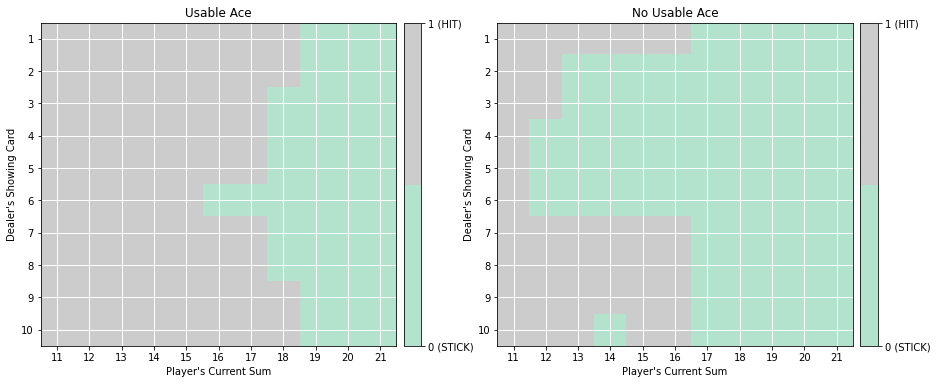

In [223]:
# plot the MC control on-policy
plot_policy(onpolicy)

In [235]:
# Running the MC on-policy learned on thy gym blackjack env
nA=env.action_space.n
onpolicy_epi_rewards = []
for i_episode in range(NUM_EPISODES_TEST):
    state = env.reset()
    while True:
        # print(state)
        action = np.random.choice(np.arange(nA), p=get_probs(onpolicy_Q[state], 0, nA)) \
                                    if state in onpolicy_Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            # print('Game has ended! Your Reward: ', reward)
            # print('You won :)\n') if reward > 0 else print('You lost :(\n')
            onpolicy_epi_rewards.append(reward)
            break

In [226]:
# Off-Policy Monte Carlo Control

def init_random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

def greedy_policy(Q):
  def policy_fn(state):
    A = np.zeros_like(Q[state], dtype=float)
    best_action = np.argmax(Q[state])
    A[best_action] = 1.0
    return A
  return policy_fn


def generate_episode_from_Q(env, Q, behavior_policy, epsilon):
  episode = []
  state = env.reset()
  while True:
    action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                  if state in Q else env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    episode.append((state, action, reward))
    state = next_state
    if done:
        break
  return episode


def update_C_Q(env, episode, C, Q, behavior_policy, target_policy, gamma):
  G = 0.0
  W = 1.0
  for t in range(len(episode))[::-1]:
    state, action, reward = episode[t]
    G = gamma * G + reward
    C[state][action] += W
    Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
    if action != np.argmax(target_policy(state)):
      # exit inner loop and proceed to next episode
      break
    W = W * 1./behavior_policy(state)[action]
  return C, Q

In [227]:
def mc_control_offpolicy(env, num_episodes, behavior_policy, max_time=100, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
  Q = defaultdict(lambda:np.zeros(env.action_space.n))
  # initialize cumulative sum
  C = defaultdict(lambda:np.zeros(env.action_space.n))
  target_policy = greedy_policy(Q)
  epsilon = eps_start
  for i_episode in range(1, num_episodes+1):
    if i_episode % 1000 == 0:
        print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        sys.stdout.flush()
    # set the value of epsilon
    epsilon = max(epsilon*eps_decay, eps_min)
    # generate an episode by following initial behaviour policy policy
    episode = generate_episode_from_Q(env, Q, behavior_policy, epsilon)
    # update the action-value function estimate using the episode
    C, Q = update_C_Q(env, episode, C, Q, behavior_policy, target_policy, gamma)
  policy = dict((s,np.argmax(v)) for s, v in Q.items())
  return policy, Q 

In [228]:
random_policy = init_random_policy(env.action_space.n)
# obtain the estimated optimal policy and action-value function
offpolicy, offpolicy_Q = mc_control_offpolicy(env, num_episodes=NUM_LEARN_EPISODES, behavior_policy=random_policy)

Episode 500000/500000.

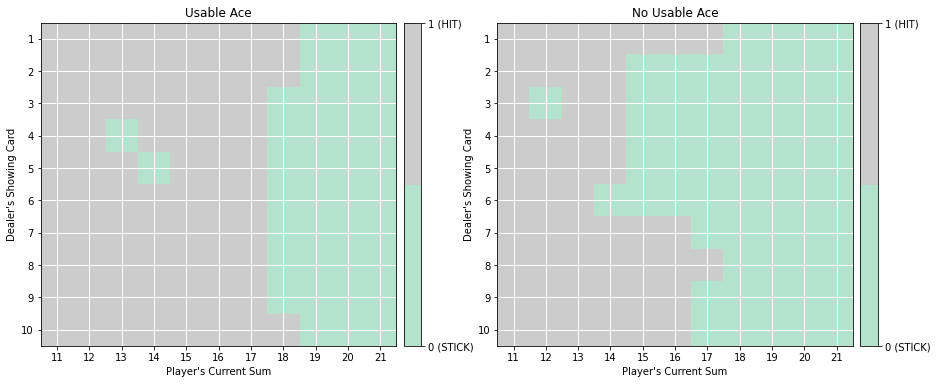

In [229]:
plot_policy(offpolicy)

In [238]:
# Running the MC off-policy learned on thy gym blackjack env
nA=env.action_space.n
offpolicy_epi_rewards = []
for i_episode in range(NUM_EPISODES_TEST):
    state = env.reset()
    while True:
        # print(state)
        action = np.random.choice(np.arange(nA), p=get_probs(offpolicy_Q[state], 0, nA)) \
                                    if state in offpolicy_Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            # print('Game has ended! Your Reward: ', reward)
            # print('You won :)\n') if reward > 0 else print('You lost :(\n')
            offpolicy_epi_rewards.append(reward)
            break

In [241]:
print('Onpolicy mean reward: {}'.format(np.mean(onpolicy_epi_rewards)))
print('Offpolicy mean reward: {}'.format(np.mean(offpolicy_epi_rewards)))
print('Onpolicy std reward: {}'.format(np.std(onpolicy_epi_rewards)))
print('Offpolicy std reward: {}'.format(np.std(offpolicy_epi_rewards)))

Onpolicy mean reward: -0.0529
Offpolicy mean reward: -0.0397
Onpolicy std reward: 0.952628778696088
Offpolicy std reward: 0.9493808034713995


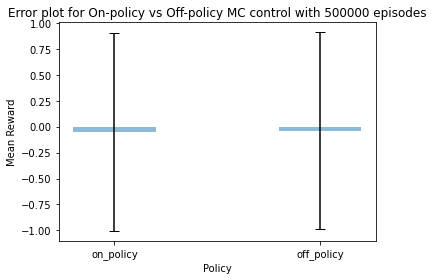

In [240]:
plt.bar(['on_policy','off_policy'], [np.mean(onpolicy_epi_rewards), np.mean(offpolicy_epi_rewards)], yerr=[np.std(onpolicy_epi_rewards), np.std(offpolicy_epi_rewards)], align='center', alpha=0.5, ecolor='black', capsize=5, width=[.4]*2)
plt.title('Error plot for On-policy vs Off-policy MC control with {} episodes'.format(NUM_EPISODES))
plt.ylabel('Mean Reward')
plt.xlabel('Policy')
plt.xticks(['on_policy','off_policy'])
plt.tight_layout()